# Click-Through Rate Prediction


The project aims to develop a machine learning model for predicting the click-through rate (CTR) of advertisements. The dataset used in this project is sourced from Kaggle and includes the following features:

- **id**: Unique identifier for each advertisement.
- **click**: Binary indicator of whether the ad was clicked (1) or not clicked (0).
- **hour**: Timestamp in the format YYMMDDHH (e.g., 14091123 represents 23:00 on September 11, 2014, UTC).
- **C1**: Anonymized categorical variable.
- **banner_pos**: Position of the banner.
- **site_id**: Identifier for the website.
- **site_domain**: Domain of the website.
- **site_category**: Category of the website.
- **app_id**: Identifier for the application.
- **app_domain**: Domain of the application.
- **app_category**: Category of the application.
- **device_id**: Identifier for the device.
- **device_ip**: IP address of the device.
- **device_model**: Model of the device.
- **device_type**: Type of the device.
- **device_conn_type**: Connection type of the device.
- **C14-C21**: Additional anonymized categorical variables.


Observed Challenge with the dataset
* There is no explicit information on how the dataset was collected
* Features like C1, C14 to C21 represents anonymized variables in order to protect the data privacy.

here is the [link](https://www.kaggle.com/c/avazu-ctr-prediction/data) to the dataset

In [1]:
# import the library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction import FeatureHasher
from sklearn.metrics import log_loss
import warnings
warnings.filterwarnings('ignore')

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

The dataset is quite large, resulting in long loading times and suboptimal PC performance. Therefore, I will load only a portion of the dataset for building this model. To determine the appropriate sample size, I will first load a single column—specifically, the hour at which the advertisement was posted. The number of unique days in this column will help me decide the number of observations to use for the project.

In [2]:
# load just the hours of observation
# df = pd.read_csv('train/busola/train.csv', usecols=['hour'])

In [3]:
# df.info()

In [4]:
# convert hour to object data type so as to extract the YYMMDD part
# df['hour'] = df['hour'].astype(str)

In [5]:
# extract YYMMDD from hour
# df['hour'] = df['hour'].apply(lambda x: x[:6])

In [6]:
# check the unique values
# df['hour'].unique()

In [7]:
# check the number of observations per each day
# df.groupby('hour')['hour'].count()

In [8]:
4122995

4122995

For building the baseline model, I will make use of a portion of the dataset. The code above is to get the number of observations corresponding to the first day. So, the first day has 4122995 observations. I will set the nrows parameter in pandas read csv method to 4122995. 

In [10]:
# Define chunk size
chunk_size = 1000  

# create an empty list to store the chunks
chunks = []

# Iterate over the dataset in chunks
for chunk in pd.read_csv('avazu-ctr-prediction/train/train.csv', nrows=4122995, chunksize=chunk_size): #4122995
    chunks.append(chunk)

In [11]:
# Concatenate all chunks into a single DataFrame
df = pd.concat(chunks, ignore_index=True)

In [11]:
# explore the dataset
df

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,1.000009e+18,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,2,15706,320,50,1722,0,35,-1,79
1,1.000017e+19,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15704,320,50,1722,0,35,100084,79
2,1.000037e+19,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15704,320,50,1722,0,35,100084,79
3,1.000064e+19,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15706,320,50,1722,0,35,100084,79
4,1.000068e+19,0,14102100,1005,1,fe8cc448,9166c161,0569f928,ecad2386,7801e8d9,...,1,0,18993,320,50,2161,0,35,-1,157
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4122990,9.999621e+18,0,14102123,1005,0,85f751fd,c4e18dd6,50e219e0,b149d645,2347f47a,...,1,3,21761,320,50,2502,0,35,-1,221
4122991,9.999646e+18,0,14102123,1002,0,85f751fd,c4e18dd6,50e219e0,a37bf1e4,7801e8d9,...,0,0,21715,320,50,2500,2,34,100233,90
4122992,9.999691e+18,0,14102123,1005,0,5b08c53b,7687a86e,3e814130,ecad2386,7801e8d9,...,1,0,17654,300,250,1994,2,39,100084,33
4122993,9.999815e+17,1,14102123,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,21757,320,50,2502,0,35,-1,221


In [12]:
df.columns

Index(['id', 'click', 'hour', 'C1', 'banner_pos', 'site_id', 'site_domain',
       'site_category', 'app_id', 'app_domain', 'app_category', 'device_id',
       'device_ip', 'device_model', 'device_type', 'device_conn_type', 'C14',
       'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21'],
      dtype='object')

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4122995 entries, 0 to 4122994
Data columns (total 24 columns):
 #   Column            Dtype  
---  ------            -----  
 0   id                float64
 1   click             int64  
 2   hour              int64  
 3   C1                int64  
 4   banner_pos        int64  
 5   site_id           object 
 6   site_domain       object 
 7   site_category     object 
 8   app_id            object 
 9   app_domain        object 
 10  app_category      object 
 11  device_id         object 
 12  device_ip         object 
 13  device_model      object 
 14  device_type       int64  
 15  device_conn_type  int64  
 16  C14               int64  
 17  C15               int64  
 18  C16               int64  
 19  C17               int64  
 20  C18               int64  
 21  C19               int64  
 22  C20               int64  
 23  C21               int64  
dtypes: float64(1), int64(14), object(9)
memory usage: 754.9+ MB


The dataset contains 24 features, most of which are categorical. Some features have been anonymized and are encoded as 'C' variables. For the baseline model, I will drop all the 'C' features and focus only on those with descriptive names. The dataset does not contain any null values. However, some features are not encoded in the correct data type. For instance, the 'hour' feature should be in a datetime format. I will convert the 'hour' feature to a datetime datatype to engineer features that could be essential for predicting ad clicks.

In [12]:
# drop C features
drop_col = ['C1', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21']

df.drop(columns=drop_col, inplace=True)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4122995 entries, 0 to 4122994
Data columns (total 15 columns):
 #   Column            Dtype  
---  ------            -----  
 0   id                float64
 1   click             int64  
 2   hour              int64  
 3   banner_pos        int64  
 4   site_id           object 
 5   site_domain       object 
 6   site_category     object 
 7   app_id            object 
 8   app_domain        object 
 9   app_category      object 
 10  device_id         object 
 11  device_ip         object 
 12  device_model      object 
 13  device_type       int64  
 14  device_conn_type  int64  
dtypes: float64(1), int64(5), object(9)
memory usage: 471.8+ MB


Next, I will convert the 'hour' feature to a datetime datatype. This will allow me to engineer new features, such as the hour of the day and the day of the week, which I believe will influence ad clicks.

In [14]:
# convert the hour columns 
df['hour'] = df['hour'].astype(str)

# reformat the date column
df['hour'] = df['hour'].apply(lambda x: '20'+x[:2]+'-'+x[2:4]+'-'+x[4:6]+'-'+x[6:])

# change the date datatype to datetime
df['hour'] = pd.to_datetime(df['hour'])

In [15]:
# rename hour to date
df = df.rename(columns={"hour": "date"})
df.head()

,id,click,date,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type
0,1.000009e+18,0,2014-10-21,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,ddd2926e,44956a24,1,2
1,1.000017e+19,0,2014-10-21,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,96809ac8,711ee120,1,0
2,1.000037e+19,0,2014-10-21,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,b3cf8def,8a4875bd,1,0
3,1.000064e+19,0,2014-10-21,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,e8275b8f,6332421a,1,0
4,1.000068e+19,0,2014-10-21,1,fe8cc448,9166c161,0569f928,ecad2386,7801e8d9,07d7df22,a99f214a,9644d0bf,779d90c2,1,0


## Feature Engineering 

In [16]:
# extract hour of the day from date
df['hour_of_day'] = df['date'].dt.hour
df

,id,click,date,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,hour_of_day
0,1.000009e+18,0,2014-10-21 00:00:00,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,ddd2926e,44956a24,1,2,0
1,1.000017e+19,0,2014-10-21 00:00:00,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,96809ac8,711ee120,1,0,0
2,1.000037e+19,0,2014-10-21 00:00:00,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,b3cf8def,8a4875bd,1,0,0
3,1.000064e+19,0,2014-10-21 00:00:00,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,e8275b8f,6332421a,1,0,0
4,1.000068e+19,0,2014-10-21 00:00:00,1,fe8cc448,9166c161,0569f928,ecad2386,7801e8d9,07d7df22,a99f214a,9644d0bf,779d90c2,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4122990,9.999621e+18,0,2014-10-21 23:00:00,0,85f751fd,c4e18dd6,50e219e0,b149d645,2347f47a,8ded1f7a,a68f22be,37b3fd2c,4ea23a13,1,3,23
4122991,9.999646e+18,0,2014-10-21 23:00:00,0,85f751fd,c4e18dd6,50e219e0,a37bf1e4,7801e8d9,07d7df22,4b572940,32f26e6e,08ac11ab,0,0,23
4122992,9.999691e+18,0,2014-10-21 23:00:00,0,5b08c53b,7687a86e,3e814130,ecad2386,7801e8d9,07d7df22,a99f214a,9f54e803,ad0177e7,1,0,23
4122993,9.999815e+17,1,2014-10-21 23:00:00,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,4da034bf,711ee120,1,0,23


For now, I will focus on feature engineering the hour of the day. I may engineer additional features later to enhance model performance. Next, I will conduct Exploratory Data Analysis (EDA) to examine the influence of each feature on ad clicks.

### Exploratory Data Analysis (EDA)

### Univariate Analysis

In [17]:
# create a dummy variable for impression
df['impression'] = 1

##### Hour of the day

In [18]:
# check how add click varies with hour of the day
hour_df = df.groupby('hour_of_day').agg({'click':'sum',
                              'impression':'sum'}).reset_index()
hour_df['CTR_hour'] = hour_df['click']/hour_df['impression'] * 100
hour_df.head()

,hour_of_day,click,impression,CTR_hour
0,0,20792,119006,17.471388
1,1,23873,137442,17.369509
2,2,31265,207471,15.069576
3,3,32830,193355,16.979132
4,4,40026,264711,15.120641


Text(0.5, 1.0, 'Hourly CTR of Ad Post')

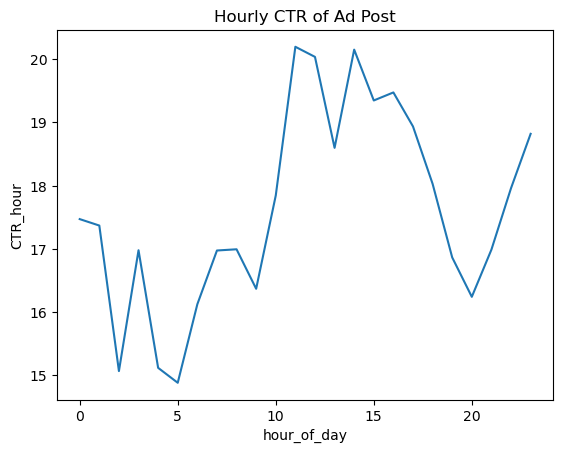

In [19]:
# plot line plot for hour variation with CTR
sns.lineplot(data=hour_df, x='hour_of_day', y='CTR_hour')
plt.title("Hourly CTR of Ad Post")

Text(0.5, 1.0, 'Hourly Click of Ad Post')

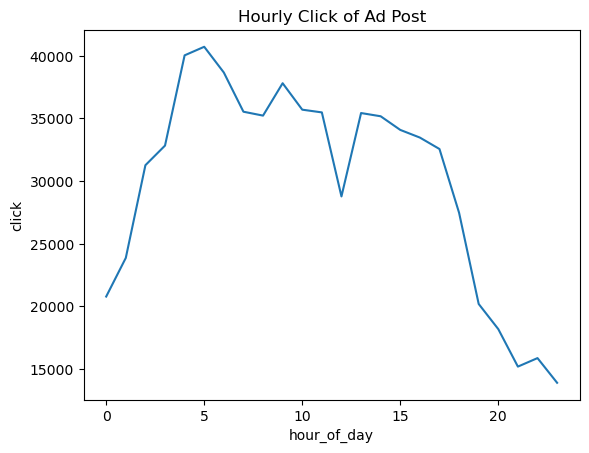

In [20]:
# plot line plot for hour variation with click
sns.lineplot(data=hour_df, x='hour_of_day', y='click')
plt.title("Hourly Click of Ad Post")

Text(0.5, 1.0, 'Hourly Impression of Ad Post')

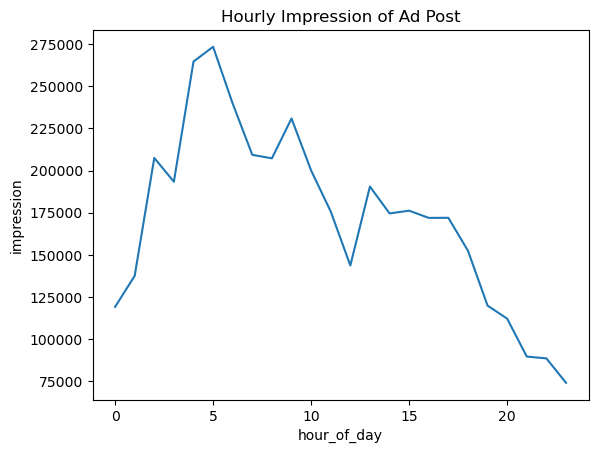

In [21]:
# plot line plot for hour variation with impression
sns.lineplot(data=hour_df, x='hour_of_day', y='impression')
plt.title("Hourly Impression of Ad Post")

The pattern of ad clicks and ad impressions appears similar, indicating that when an ad is shown to a large number of people, the number of clicks also increases. Most people visit the platform and see the ads between 4 AM and 7 AM, which is also when the highest number of clicks occur. However, comparing this pattern with the click-through rate (CTR) reveals that ads posted during peak impression times are not the most profitable, as they have the lowest CTR during these periods. In contrast, ads posted between 10 AM and 3 PM experience the highest CTR. This suggests that the hour of the day is a significant predictor of ad clicks.

##### Click

Text(0.5, 1.0, 'Click Distribution')

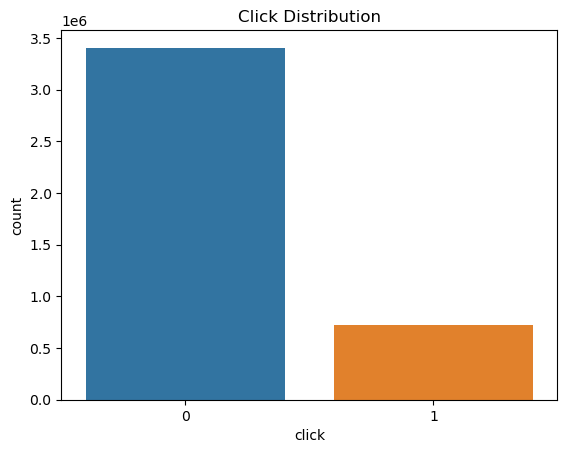

In [22]:
# check the distribution of click
sns.countplot(data=df, x='click')
plt.title("Click Distribution")

In [23]:
# percentage of the add click
df[df['click'] == 1].shape[0]/df.shape[0] * 100

17.419812539185713

As expected, the dataset has more observations for non-clicked ads than clicked ads. Out of all the ads posted, only about 17% are clicked, indicating a significant class imbalance. Despite this imbalance, I will proceed with building my baseline model without addressing it initially.

##### banner_pos

I expect the position of the ad banner on the website to significantly influence ad clicks. Strategically positioned ads are more likely to be noticed and clicked on. In the dataset, the `banner_pos` feature is encoded with values ranging from 0 to 7. I will analyze how ad clicks vary based on the position of the ad banners.

The datatype of banner info should be object but it is current int. I will convert it to object datatype

In [24]:
# convert banner_pos datatype to object
df['banner_pos'] = df['banner_pos'].astype(str)

In [25]:
# explore ad click by banner position
banner_df = df.groupby('banner_pos').agg({'click':'sum',
                             'impression':'sum'}).reset_index()
banner_df['CTR_banner'] = banner_df['click']/banner_df['impression']*100

banner_df

,banner_pos,click,impression,CTR_banner
0,0,512630,3076333,16.663671
1,1,204429,1040891,19.639809
2,2,152,1309,11.611917
3,3,0,17,0.000000
4,4,73,496,14.717742
5,5,236,2635,8.956357
6,7,698,1314,53.120244


Text(0.5, 1.0, 'Banner Position vs. CTR')

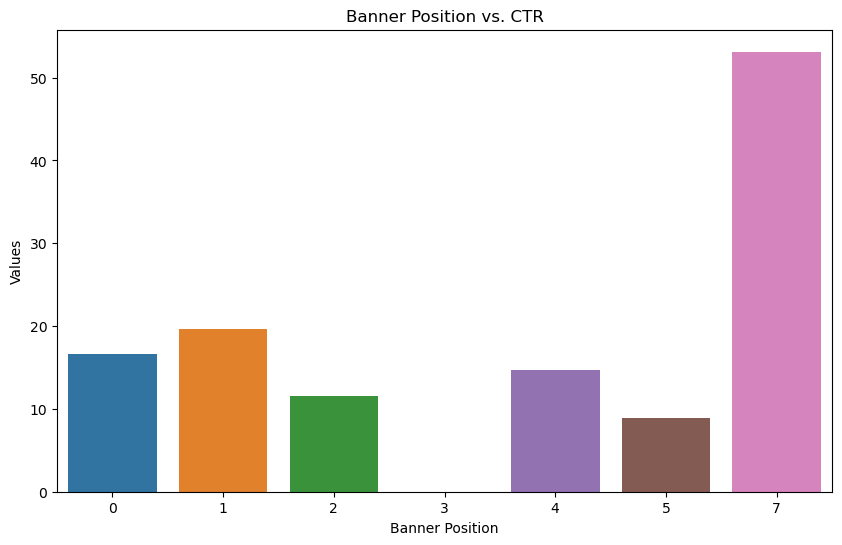

In [26]:
# Plot the chart
plt.figure(figsize=(10, 6))
sns.barplot(data=banner_df, x='banner_pos', y='CTR_banner')

plt.xlabel('Banner Position')
plt.ylabel('Values')
plt.title('Banner Position vs. CTR')

When the ad banner is positioned at 7, users are more likely to click on the ad. However, both impressions and clicks for ads at position 7 are minimal. This suggests that sites and apps placing ads in position 7 are less frequently visited by users, but when users do visit, they are more inclined to click on the ads.

### Site_id


I expect the specfic site where the ad is placed to affect the CTR. NOw, I will explore how the ad click differ base on the website where it is placed

In [27]:
# explore ad click by site_id position
site_id_df = df.groupby('site_id').agg({'click':'sum',
                             'impression':'sum'}).reset_index()
site_id_df['CTR_site'] = site_id_df['click']/site_id_df['impression']*100

site_id_df

,site_id,click,impression,CTR_site
0,00255fb4,3,15,20.000000
1,003cf93d,0,2,0.000000
2,00476056,1,1,100.000000
3,006ab81e,6,37,16.216216
4,009f04fc,0,4,0.000000
...,...,...,...,...
2860,ffcb6b9a,29,270,10.740741
2861,ffcff165,6,81,7.407407
2862,ffdcedfa,0,4,0.000000
2863,fffde64d,0,4,0.000000


In [28]:
# check the top 10 site base on CTR

top_20_CTR_site_id = site_id_df.sort_values(by='CTR_site', ascending=False).head(20)
top_20_CTR_site_id

,site_id,click,impression,CTR_site
1604,8ddfee4e,2,2,100.0
170,0d482273,3,3,100.0
2175,c30b87cb,2,2,100.0
2186,c440e2b7,1,1,100.0
428,24e04145,1,1,100.0
2197,c5756186,1,1,100.0
1866,a6263cff,1,1,100.0
853,46e56230,1,1,100.0
1057,57ef2c87,1,1,100.0
414,23b9d28c,2,2,100.0


Text(0.5, 1.0, 'Top 20 Site Id by CTR')

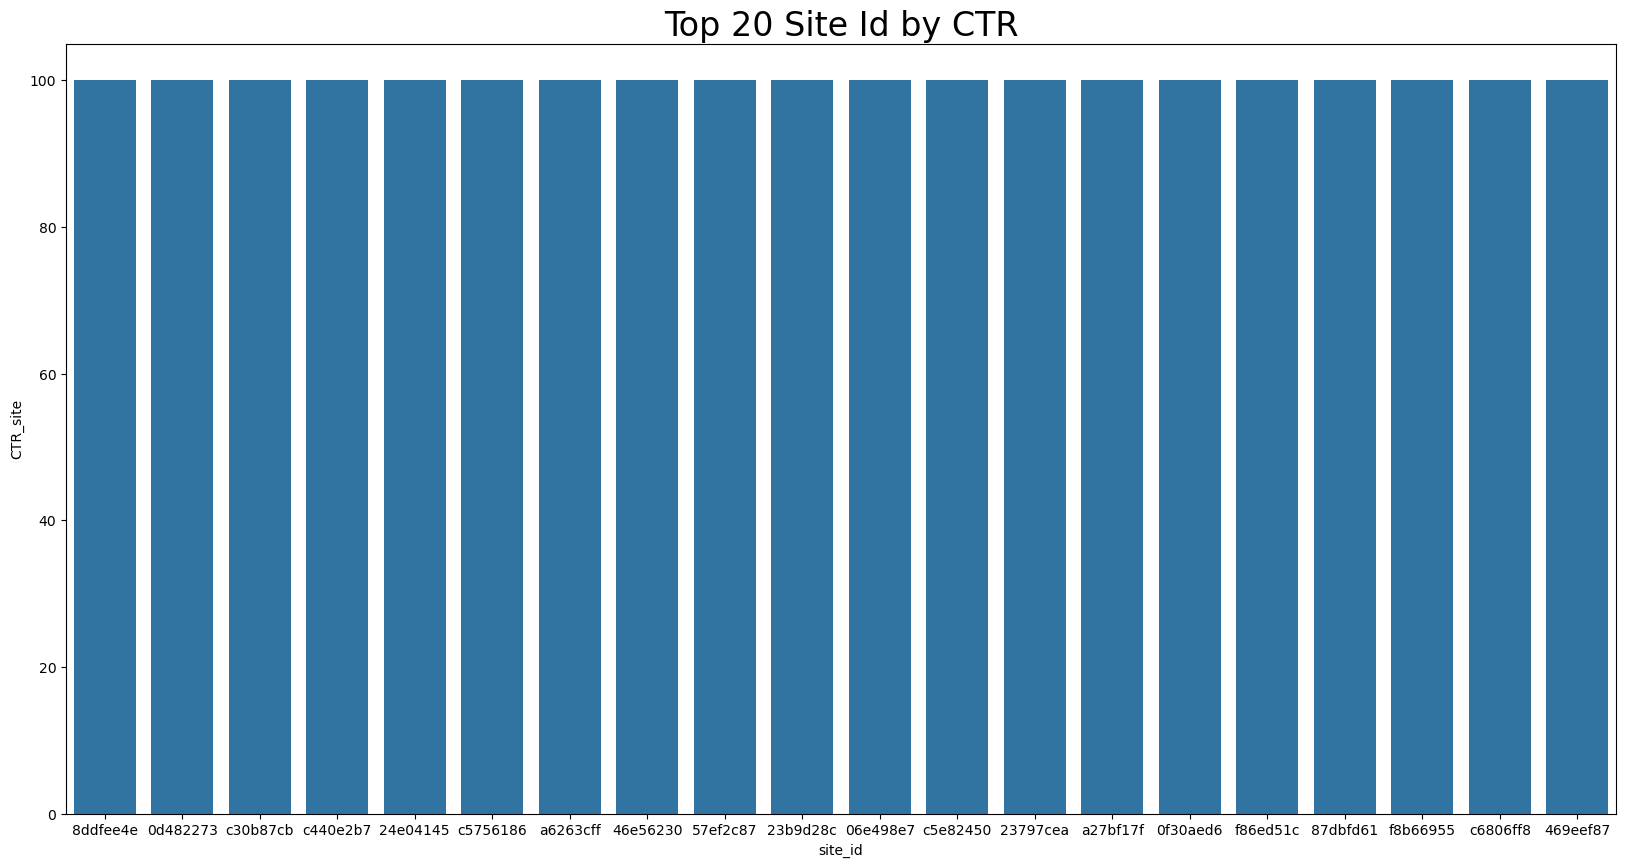

In [29]:
plt.figure(figsize=(20,10))
sns.barplot(data=top_20_CTR_site_id, x='site_id', y='CTR_site', color=sns.color_palette()[0])
plt.title('Top 20 Site Id by CTR', fontdict={'size':24})

While most of the top 10 site with the highest CTR has just one impression and one click, that is not much enough to agree they have 100% CTR. 

In [30]:
# Merge metrics back to the main dataframe
df = df.merge(banner_df[['banner_pos', 'CTR_banner']], on='banner_pos')
df = df.merge(site_id_df[['site_id', 'CTR_site']], on='site_id')
df = df.merge(hour_df[['hour_of_day', 'CTR_hour']], on='hour_of_day')

In [31]:
df

,id,click,date,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,hour_of_day,impression,CTR_banner,CTR_site,CTR_hour
0,1.000009e+18,0,2014-10-21 00:00:00,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,ddd2926e,44956a24,1,2,0,1,16.663671,20.377514,17.471388
1,1.000017e+19,0,2014-10-21 00:00:00,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,96809ac8,711ee120,1,0,0,1,16.663671,20.377514,17.471388
2,1.000037e+19,0,2014-10-21 00:00:00,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,b3cf8def,8a4875bd,1,0,0,1,16.663671,20.377514,17.471388
3,1.000064e+19,0,2014-10-21 00:00:00,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,e8275b8f,6332421a,1,0,0,1,16.663671,20.377514,17.471388
4,1.000095e+19,1,2014-10-21 00:00:00,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,37e8da74,5db079b5,1,2,0,1,16.663671,20.377514,17.471388
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4122990,6.950154e+18,1,2014-10-21 23:00:00,2,424f0ecf,8a704386,f66779e6,ecad2386,7801e8d9,07d7df22,a99f214a,52760bc9,2203a096,1,0,23,1,11.611917,12.879485,18.819313
4122991,7.684567e+18,0,2014-10-21 23:00:00,2,424f0ecf,8a704386,f66779e6,ecad2386,7801e8d9,07d7df22,a99f214a,b52787d8,d787e91b,1,0,23,1,11.611917,12.879485,18.819313
4122992,8.958540e+18,0,2014-10-21 23:00:00,2,424f0ecf,8a704386,f66779e6,ecad2386,7801e8d9,07d7df22,a99f214a,84e1fa7a,779d90c2,1,0,23,1,11.611917,12.879485,18.819313
4122993,9.522808e+17,0,2014-10-21 23:00:00,2,424f0ecf,8a704386,f66779e6,ecad2386,7801e8d9,07d7df22,a99f214a,cef1fad3,8a4875bd,1,0,23,1,11.611917,12.879485,18.819313


### Modeling

To build the baseline model, I will make use of banner_pos and site_id, and hour of the day. For the baseline model, I will use Logistic Regression since it is a classification problem.

For training the baseline model, I will use hashing to convert the categorical variables to fixed-size numerical representations. Handling categorical features using hashing can help to reduce dataset dimensionality. 

In [32]:
# Initialize FeatureHasher
hasher = FeatureHasher(n_features=10, input_type='string')

In [33]:
# Apply hashing on categorical features
categorical_features = ['banner_pos', 'site_id']
hashed_features = hasher.transform(df[categorical_features].astype(str).values)

In [34]:
# Convert hashed features to DataFrame
hashed_df = pd.DataFrame(hashed_features.toarray(), columns=[f'feature_{i}' for i in range(hashed_features.shape[1])])

In [35]:
df

,id,click,date,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,hour_of_day,impression,CTR_banner,CTR_site,CTR_hour
0,1.000009e+18,0,2014-10-21 00:00:00,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,ddd2926e,44956a24,1,2,0,1,16.663671,20.377514,17.471388
1,1.000017e+19,0,2014-10-21 00:00:00,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,96809ac8,711ee120,1,0,0,1,16.663671,20.377514,17.471388
2,1.000037e+19,0,2014-10-21 00:00:00,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,b3cf8def,8a4875bd,1,0,0,1,16.663671,20.377514,17.471388
3,1.000064e+19,0,2014-10-21 00:00:00,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,e8275b8f,6332421a,1,0,0,1,16.663671,20.377514,17.471388
4,1.000095e+19,1,2014-10-21 00:00:00,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,37e8da74,5db079b5,1,2,0,1,16.663671,20.377514,17.471388
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4122990,6.950154e+18,1,2014-10-21 23:00:00,2,424f0ecf,8a704386,f66779e6,ecad2386,7801e8d9,07d7df22,a99f214a,52760bc9,2203a096,1,0,23,1,11.611917,12.879485,18.819313
4122991,7.684567e+18,0,2014-10-21 23:00:00,2,424f0ecf,8a704386,f66779e6,ecad2386,7801e8d9,07d7df22,a99f214a,b52787d8,d787e91b,1,0,23,1,11.611917,12.879485,18.819313
4122992,8.958540e+18,0,2014-10-21 23:00:00,2,424f0ecf,8a704386,f66779e6,ecad2386,7801e8d9,07d7df22,a99f214a,84e1fa7a,779d90c2,1,0,23,1,11.611917,12.879485,18.819313
4122993,9.522808e+17,0,2014-10-21 23:00:00,2,424f0ecf,8a704386,f66779e6,ecad2386,7801e8d9,07d7df22,a99f214a,cef1fad3,8a4875bd,1,0,23,1,11.611917,12.879485,18.819313


In [36]:
# Combine hashed features with other features
X = pd.concat([hashed_df, df.loc[:, ['CTR_banner', 'CTR_site']]], axis=1) 
y = df['click']  

In [37]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [38]:
# Model Training and Evaluation
def evaluate_regression_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    return rmse, r2

### Logistic Regression

In [39]:
# Logistic Regression for probability estimation
model = LogisticRegression(solver='liblinear')
model.fit(X_train, y_train)

LogisticRegression(solver='liblinear')

In [40]:
# Predict probabilities
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probabilities of the positive class

In [41]:
# Evaluation
def evaluate_classification_model(y_true, y_pred_proba):
    loss = log_loss(y_true, y_pred_proba)
    return loss

logloss = evaluate_classification_model(y_test, y_pred_proba)

print(f"Log Loss: {logloss}")

Log Loss: 0.42686999813244153


The metric for evaluating the performance of the click-through model is log loss. Currently, the log loss for the baseline model is 0.46, which I aim to improve over time. The model is currently biased towards predicting non-clicks, which could be due to the class imbalance. Treating the class imbalance could solve this biase